In [1]:
import numpy as np
import pandas as pd 

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
os.path.join(PROJECT_ROOT_DIR)
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
CLEAREDDATA_PATH = os.path.join(PROJECT_ROOT_DIR, "cleareddata")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(CLEAREDDATA_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

from pipe_classes import *

./data/nyc_benchmarking_disclosure_2017_consumption_data.xlsx
./data/scotch_review.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
data = pd.read_excel(PROJECT_ROOT_DIR+'/data/nyc_benchmarking_disclosure_2017_consumption_data.xlsx','Information and Metrics')

In [3]:
data = data.replace({'Not Available': np.nan})

In [4]:
data.select_dtypes(exclude=['number']).keys()

Index(['Property Name', 'Parent Property Id', 'Parent Property Name',
       'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Address 2 (self-reported)', 'Postal Code', 'Street Number',
       'Street Name', 'Borough', 'DOF Gross Floor Area (ft²)',
       'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type', '2nd Largest Property Use Type',
       '3rd Largest Property Use Type', 'Metered Areas (Energy)',
       'Metered Areas  (Water)', 'Annual Maximum Demand (MM/YYYY)',
       'Water Required?', 'Generation Date',
       'DOF Benchmarking Submission Status'],
      dtype='object')

In [5]:
data.dropna(subset=["ENERGY STAR Score"],inplace=True)

In [6]:
data["ENERGY STAR Score"].describe()

count    25454.000000
mean        53.927163
std         32.573629
min          1.000000
25%         25.000000
50%         56.000000
75%         83.000000
max        100.000000
Name: ENERGY STAR Score, dtype: float64

### First exercise: SVC without PCA or collinear features remover and without the sqrt-log feature adder

In [8]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

reg_target="ENERGY STAR Score"
spec_cols=['Water Use (All Water Sources) (kgal)','Largest Property Use Type - Gross Floor Area (ft²)','index','Order','Property Id']

prep_pipeline = Pipeline([
        ('deleter', MissVals_Deleter()),
        ('outremover', Outliers_Remover(['Site EUI (kBtu/ft²)'])),
        ('feature_encoder', Feature_Encoder(reg_target,['Borough', 'Largest Property Use Type'])),
        ('speccolumn_remover', SpecColumn_Remover(spec_cols)),
        ('strattraintest_splitter', StratTrainTest_Splitter(reg_target, [0., 20., 45., 70., 90., np.inf], [1, 2, 3, 4, 5], verbose = True)),
    ])

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

X, X_test, y, y_test = prep_pipeline.fit_transform(data)

X = num_pipeline.fit_transform(X)
X_test = num_pipeline.fit_transform(X_test)
X.shape

Your selected dataframe has 60 columns.
There are 37 columns that have missing values.
By the remove percentage criterion 50, we may remove 19 columns.
(0, 52)
(24646, 52)
               Overall  Stratified    Random  Rand. %error  Strat. %error
(0.0, 20.0]   0.194474    0.194482  0.190019     -2.290702       0.004250
(20.0, 45.0]  0.197557    0.197593  0.197728      0.086291       0.017833
(45.0, 70.0]  0.223647    0.223695  0.232756      4.073140       0.021484
(70.0, 90.0]  0.198856    0.198810  0.192859     -3.015614      -0.023108
(90.0, inf]   0.185466    0.185421  0.186638      0.631712      -0.024581


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(17252, 51)

In [9]:
from sklearn.preprocessing import KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
#strategy{‘uniform’, ‘quantile’, ‘kmeans’}, (default=’quantile’)

yt=enc.fit_transform(y)
yt_test=enc.fit_transform(y_test)

In [10]:
yyt=y.copy(deep=True)
yyt['cat']=yt
yyt.head()

,ENERGY STAR Score,cat
18645,42.0,4.0
10893,83.0,8.0
982,45.0,4.0
12530,100.0,9.0
10883,43.0,4.0


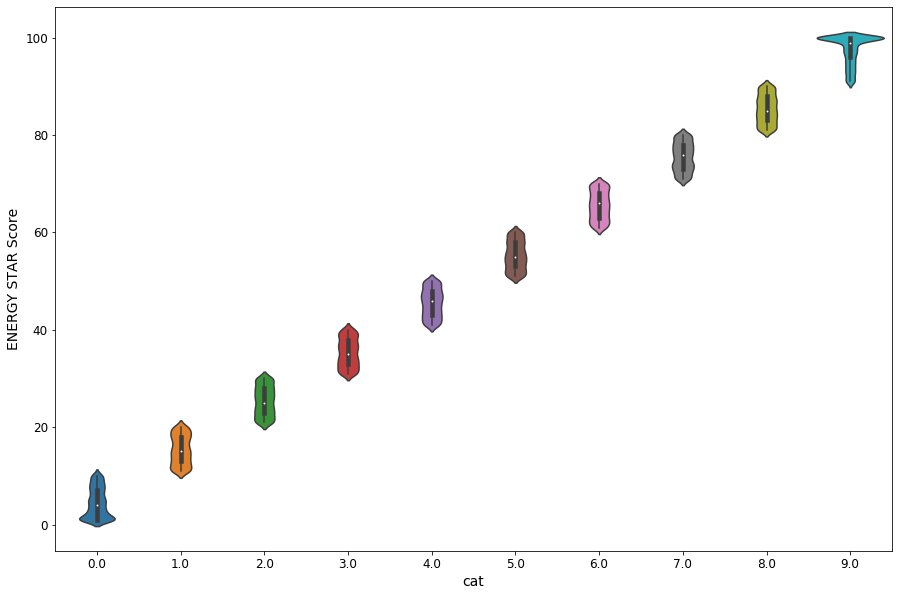

In [12]:
a4_dims = (15, 10)

#sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.violinplot(x='cat', y=reg_target, data=yyt)

In [13]:
def results_display(reg, X, X_test, y, y_test):
    from sklearn import metrics
    from timeit import default_timer as timer
    start = timer()
    reg.fit(X, y)
    ###train set
    X_pred = reg.predict(X)
    # Model Accuracy: how often is the classifier correct?
    train_acc = metrics.accuracy_score(y, X_pred)
    # The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    train_prec = metrics.precision_score(y, X_pred, pos_label='positive', average='micro')
    # The recall is intuitively the ability of the classifier to find all the positive samples.
    train_recall = metrics.recall_score(y, X_pred, pos_label='positive', average='micro')
    ###test set
    X_test_pred = reg.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, X_test_pred)
    test_prec = metrics.precision_score(y_test, X_test_pred, pos_label='positive', average='micro')
    test_recall = metrics.recall_score(y_test, X_test_pred, pos_label='positive', average='micro')
    end = timer()
    print(str(reg))
    print('Train set: Regressor name, Acc, Prec, Recall')
    print(reg.__class__.__name__, round(train_acc,3), round(train_prec,3), round(train_recall,3))
    print('Test set: Regressor name, Acc, Prec, Recall')
    print(reg.__class__.__name__, round(test_acc,3), round(test_prec,3), round(test_recall,3))
    print('Time consumption [s]: ', round((end - start),3))
    print('---------------------------------------------------------')

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', 
                           metric_params=None, n_jobs=None)

In [17]:
results_display(clf, X, X_test, yt, yt_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Train set: Regressor name, Acc, Prec, Recall
KNeighborsClassifier 0.641 0.641 0.641
Test set: Regressor name, Acc, Prec, Recall
KNeighborsClassifier 0.456 0.456 0.456
Time consumption [s]:  93.724
---------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [18]:
some_data = X[:10]
some_labels = yt[:10]

print("Predictions:", clf.predict(some_data))
print("Labels:     ", some_labels[:,-1])

Predictions: [4. 8. 4. 9. 5. 2. 7. 6. 0. 9.]
Labels:      [4. 8. 4. 9. 4. 2. 8. 8. 0. 9.]


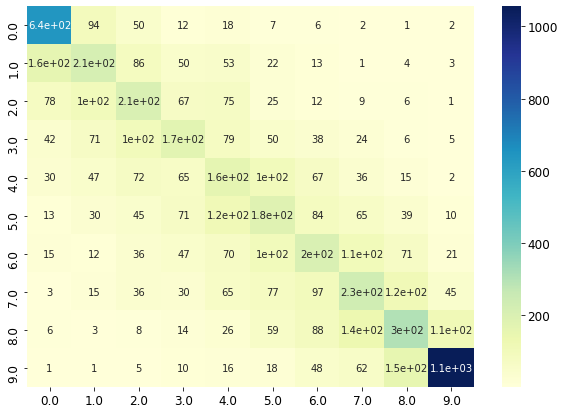

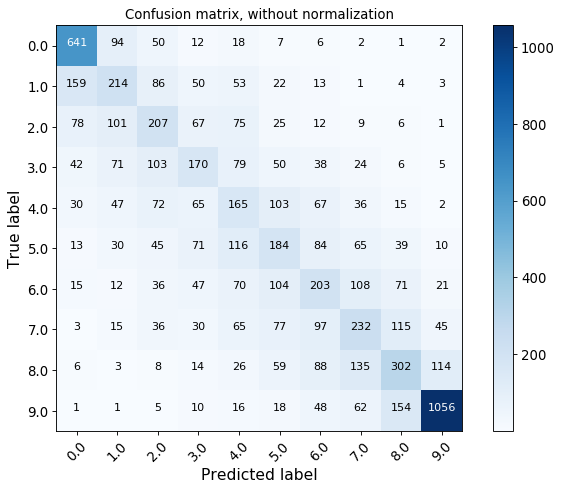

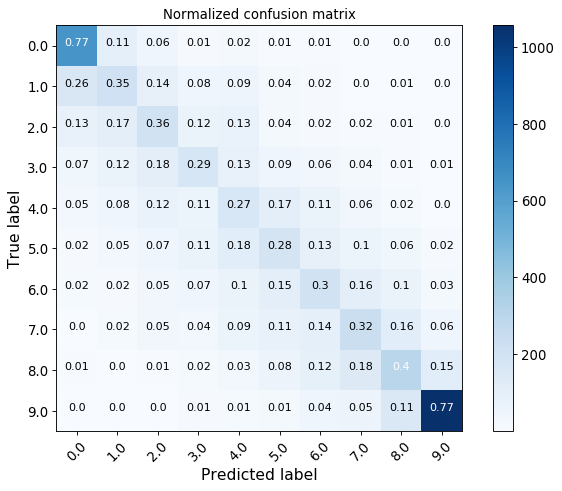

In [19]:
import itertools
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],decimals=2)
        #print("Normalized confusion matrix")
        plt.title("Normalized confusion matrix")
        plt.colorbar()
    else:
        #print("Confusion matrix, without normalization")
        plt.title('Confusion matrix, without normalization')
        plt.colorbar()

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
class_names = sorted(yyt['cat'].unique())  
# Compute confusion matrix
cnf_matrix = confusion_matrix(yt_test, y_pred)
np.set_printoptions(precision=2)

# Plot with Seaborn
df_cm = pd.DataFrame(cnf_matrix, index = sorted(yyt['cat'].unique()),
                  columns = sorted(yyt['cat'].unique()))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, cmap="YlGnBu", annot=True)

# Plot non-normalized confusion matrix
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                     title='Normalized confusion matrix')

plt.show()

In [22]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from timeit import default_timer as timer

start = timer()

tuned_parameters = [{'n_neighbors': [5,10],
                    'weights': ['uniform', 'distance'],
                    'algorithm': ['ball_tree', 'kd_tree', 'brute']}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        KNeighborsClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X, yt)
    end = timer()
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yt_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print('---------------------------------------------------------------------')
    print('Full time consumption [s]: ', round((end - start),3))
    print('---------------------------------------------------------------------') 

# Tuning hyper-parameters for precision



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters set found on development set:

{'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}

Grid scores on development set:

0.400 (+/-0.017) for {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
0.507 (+/-0.016) for {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
0.375 (+/-0.013) for {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}
0.507 (+/-0.019) for {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}
0.400 (+/-0.017) for {'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'uniform'}
0.507 (+/-0.016) for {'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'distance'}
0.375 (+/-0.013) for {'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'uniform'}
0.507 (+/-0.019) for {'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'distance'}
0.400 (+/-0.017) for {'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'uniform'}
0.507 (+/-0.016) for {'algorithm': 'brute', 'n_neighbors': 5, '

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters set found on development set:

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}

Grid scores on development set:

0.403 (+/-0.018) for {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
0.508 (+/-0.016) for {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
0.380 (+/-0.014) for {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}
0.508 (+/-0.019) for {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}
0.403 (+/-0.018) for {'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'uniform'}
0.508 (+/-0.016) for {'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'distance'}
0.380 (+/-0.014) for {'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'uniform'}
0.508 (+/-0.019) for {'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'distance'}
0.403 (+/-0.018) for {'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'uniform'}
0.508 (+/-0.016) for {'algorithm': 'brute', 'n_neighbors': 5, 